# Transfer Learning

전이 학습(Transfer Learning)은 특정 분야에서 학습된 신경망의 일부 능력을 유사하거나 전혀 새로운 분야에서 사용되는 신경망의 학습에 이용하는 것을 의미합니다.

지난 수업을 회상해보면, 이미지 분류를 예로 들어 Resnet이나 VGG 등과 같은 신경망의 구성 중 앞단은 CNN 레이어로 구성되어 있습니다. 이미 학습된 신경망의 이미지 특징 추출 능력은 다른 데이터셋에서도 활용될 수 있습니다. ImageNet과 같은 수만에서 수천만장의 이미지를 통해 이미 학습된 높은 성능을 갖는 Resnet이나 VGG 신경망의 특징 추출 능력을 그대로 이용하고, 주로 선형(Affine; 가중치와 편향에 대한 행렬 연산; Fully Connected Layer) 레이어만을 변경하여 이 변경된 레이어만을 재학습시키는 것이 전이 학습입니다.

이 노트북에서는 [ImageNet dataset](http://www.image-net.org/)에서 학습된 [VGGNet](https://arxiv.org/pdf/1409.1556.pdf)을 활용해볼 것입니다. ResNet 등은 동일한 방법으로 사용하시면 됩니다.

![image.png](https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png)

Fully connected layer를 변경하고 학습하여 전이학습이 가능함을 보일 것입니다.
하기 자료는 [the CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/)를 참고해 완성했습니다.

---

In [1]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip


--2021-10-16 00:33:57--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.8.46
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.8.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229734282 (219M) [application/zip]
Saving to: ‘flower-photos.zip’

flower-photos.zip   100%[===================>] 219.09M  16.5MB/s    in 15s     

2021-10-16 00:34:14 (14.2 MB/s) - ‘flower-photos.zip’ saved [229734282/229734282]



In [2]:
!unzip flower-photos.zip

Archive:  flower-photos.zip
   creating: flower_photos/
  inflating: flower_photos/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/flower_photos/
  inflating: __MACOSX/flower_photos/._.DS_Store  
  inflating: flower_photos/LICENSE.txt  
   creating: flower_photos/test/
  inflating: flower_photos/test/.DS_Store  
   creating: __MACOSX/flower_photos/test/
  inflating: __MACOSX/flower_photos/test/._.DS_Store  
   creating: flower_photos/test/daisy/
  inflating: flower_photos/test/daisy/14332947164_9b13513c71_m.jpg  
  inflating: flower_photos/test/daisy/14333681205_a07c9f1752_m.jpg  
  inflating: flower_photos/test/daisy/14350958832_29bdd3a254.jpg  
  inflating: flower_photos/test/daisy/14354051035_1037b30421_n.jpg  
  inflating: flower_photos/test/daisy/14372713423_61e2daae88.jpg  
  inflating: flower_photos/test/daisy/14399435971_ea5868c792.jpg  
  inflating: flower_photos/test/daisy/14402451388_56545a374a_n.jpg  
  inflating: flower_photos/test/daisy/14421389519_d5fd353eb4.jpg

## Flower power

우리는 VGGNet을 이용해 꽃 사진들을 분류할 것입니다. 우리가 가진 GPU를 먼저 확인하고, 이후 GPU위에서 학습할 것입니다.


### Download Data

[링크](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip)를 통해 압축파일을 다운받고, `flower_photos/` 디렉토리를 만들어서 사진을 저장할 것입니다.

In [3]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available() # True or False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load and Transform our Data

PyTorch의 [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) 는 아래와 같이 정돈되어야 합니다. class 안에 데이터가 저장되도록 되어야합니다:

```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```
이 때 root 폴더는 `flower_photos/train/`이며, class 폴더는 flower type이 되어야합니다.

In [5]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

print(train_dir, test_dir)
# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

flower_photos/train/ flower_photos/test/


### Transforming the Data


VGG pretrained model은 input데이터의 크기로 `224x224`를 기대합니다. 그래서 이곳에서 활용하는 데이터의 크기도 224로 만들어주어야합니다.

In [6]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


### DataLoaders and Data Visualization

In [7]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [9]:
train_loader

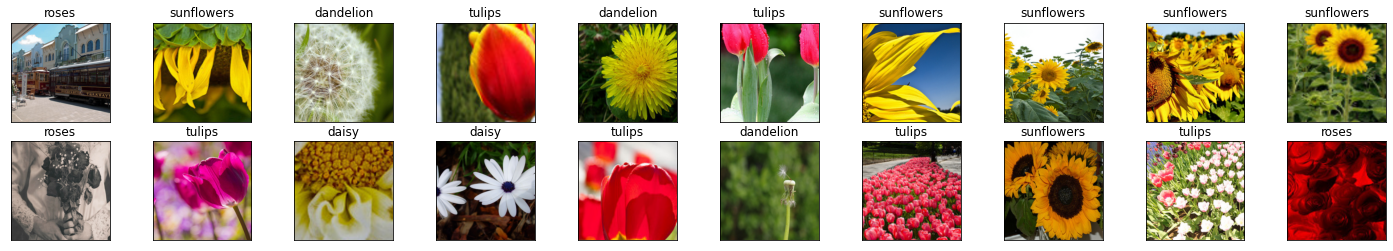

In [10]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [11]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
print(vgg16.classifier[6])
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

Linear(in_features=4096, out_features=1000, bias=True)
4096
1000


In [16]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
  
# vgg16.classifier.parameters() weight bias -> layer마다 2개의 parameter vector(matrix)가 나온다.

---
### Final Classifier Layer

VGG의 마지막 Fully connected Layer를 새로운 layer로 대체할 것입니다.

> flower classification task에 어울리는 개수의 node를 가진 layer로 바꿔줘야합니다.

Network를 출력해보면 `vgg16.classifier[6]` 가 마직 layer임을 알 수 있고, 이것을 대체해야함을 알 수 있습니다.

In [17]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
print(vgg16)

5
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

`vgg.classifier.parameters()` 만을 trainable parameter로 만들어주어서 학습할 것입니다.

SGD를 사용하고, CrossEntropyLoss를 사용합니다.

In [19]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

---
## Training

하기의 코드처럼 train code를 만들어 학습합니다.

In [20]:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1, Batch 20 loss: 1.5780421972274781
Epoch 1, Batch 40 loss: 1.3694812059402466
Epoch 1, Batch 60 loss: 1.2100997626781465
Epoch 1, Batch 80 loss: 1.1248075217008591
Epoch 1, Batch 100 loss: 1.0577947527170182
Epoch 1, Batch 120 loss: 1.0727580010890960
Epoch 1, Batch 140 loss: 0.9569097578525543
Epoch 2, Batch 20 loss: 0.8457179605960846
Epoch 2, Batch 40 loss: 0.8189053893089294
Epoch 2, Batch 60 loss: 0.8894609719514847
Epoch 2, Batch 80 loss: 0.7610978335142136
Epoch 2, Batch 100 loss: 0.8145960658788681
Epoch 2, Batch 120 loss: 0.8120436817407608
Epoch 2, Batch 140 loss: 0.7692282587289810


---
## Testing

Below you see the test accuracy for each flower class.

In [21]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.723319

Test Accuracy of daisy: 75% (69/92)
Test Accuracy of dandelion: 92% (122/132)
Test Accuracy of roses: 67% (61/91)
Test Accuracy of sunflowers: 74% (75/101)
Test Accuracy of tulips: 62% (77/124)

Test Accuracy (Overall): 74% (404/540)


### Visualize Sample Test Results

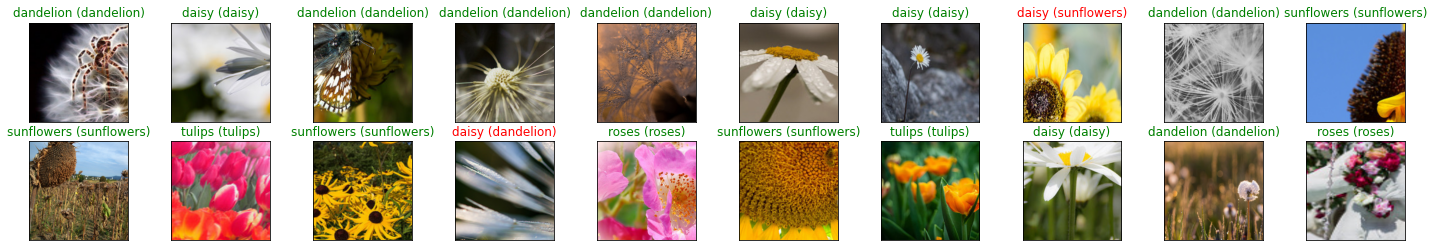

In [22]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# # plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))